In [53]:
modelPath = "Clickbait"
checkpoint = "bert-base-cased"
                                              # "cmarkea/distilcamembert-base-sentiment"
                                              # "cmarkea/distilcamembert-base" (accuracy=0,69)
                                              # "camembert-base"
                                              # "microsoft/Multilingual-MiniLM-L12-H384" (accuracy=0,64)
                                              # "nlptown/bert-base-multilingual-uncased-sentiment"
                                              # "distilbert-base-uncased-finetuned-sst-2-english"
                                              # "bert-base-uncased"
problem_type =  "regression"                  # Possible values: "regression", "single_label_classification", "multi_label_classification"
num_labels = 1                                # 5
dataCuratedPath = "Data/Curated"              # Données pour tous les sites du 1er janvier 2021 au 30 avril 2021
                                              # Données juste pour le site "Actualités, trucs et astuces" entre le 1er mai et le 31 juillet 2021.
                                              # Les colonnes sont les suivantes, séparées par des ";" :
                                              #    Page name;Title;Publish time;People Reached;Link Clicks
actualOutput = 'truthMean'
computedOutput = "labelC"
inputColumn = 'postText'
removeColumns = ['postText', 'targetTitle', 'targetDescription', 'id', 'truthMean'] # Il faut enlever les colonnes de type texte
splitFactor = 0.2                             # Proportion de données réservées pour les tests
push_to_hub = False
learning_rate = 5e-5
weight_decay=0.01

In [2]:
import torch
import numpy as np

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(
   checkpoint,
   problem_type=problem_type,
   num_labels = num_labels)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [4]:
print(tokenizer("Bonjour, comment ça va ?"))
print(tokenizer.tokenize("Hello, how are you?"))
print(tokenizer.encode("Bonjour, comment ça va ?"))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize("Bonjour, comment ça va ?")))
print(tokenizer.convert_ids_to_tokens(tokenizer.encode("Bonjour, comment ça va ?")))
print(tokenizer.decode(tokenizer.encode("Bonjour, comment ça va ?")))

{'input_ids': [101, 17182, 25028, 1197, 117, 7368, 253, 1161, 191, 1161, 136, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['Hello', ',', 'how', 'are', 'you', '?']
[101, 17182, 25028, 1197, 117, 7368, 253, 1161, 191, 1161, 136, 102]
[17182, 25028, 1197, 117, 7368, 253, 1161, 191, 1161, 136]
['[CLS]', 'Bon', '##jou', '##r', ',', 'comment', 'ç', '##a', 'v', '##a', '?', '[SEP]']
[CLS] Bonjour, comment ça va? [SEP]


In [5]:
import datasets as ds

In [6]:
curated = ds.load_from_disk(dataCuratedPath)

In [7]:
curated.to_pandas()

,postText,targetTitle,targetDescription,truthMean,id
0,"Panama Papers: Europol links 3,500 names to su...","Panama Papers: Europol links 3,500 names to su...",Law enforcement agency analysis uncovers proba...,0.066667,804113781580328960
1,The key to truly great chicken soup,A Superior Chicken Soup,For the best rendition of this American classi...,0.733333,804119512010424320
2,Afghan policewomen face down their fears to serve,100 Women 2016: On the frontline with the wome...,The Afghan women risking all to join the police.,0.333333,804121272967983104
3,Conservatives are watching less football this ...,Older Viewers and Conservatives Are Watching L...,"Many factors are dragging down NFL ratings, in...",0.066667,804123103995580416
4,Richard Sherman weighs in on Cam Newton’s stru...,Seattle Seahawks Richard Sherman Says 'Karma' ...,"Seattle Seahawks news, rumors, scores, schedul...",0.133333,804126501117435904
...,...,...,...,...,...
21907,Man who received world's first penis transplan...,World's first penis transplant patient is set ...,"Surgeons at Stellenbosch University, who carri...",0.600000,609056814819323905
21908,"RT @NYTSports: Abby didn't start, team couldn'...","At Women’s World Cup, Tie Leaves U.S. on Solid...",With Abby Wambach not starting for the first t...,0.266667,610125815116865536
21909,Obama defends Affordable Care Act ahead of Sup...,Obama Defends Health Law Ahead of Supreme Cour...,President Obama talks at the G7 summit in Germ...,0.400000,608338587495628801
21910,New study of the Deflategate report concludes ...,Deflating ‘Deflategate’,A new study weakens the case against the Patri...,0.400000,609684420082180096


In [8]:
longueur= len(curated)
longueur

21912

In [9]:
trie=sorted(curated[actualOutput])

In [10]:
import matplotlib.pyplot as plt

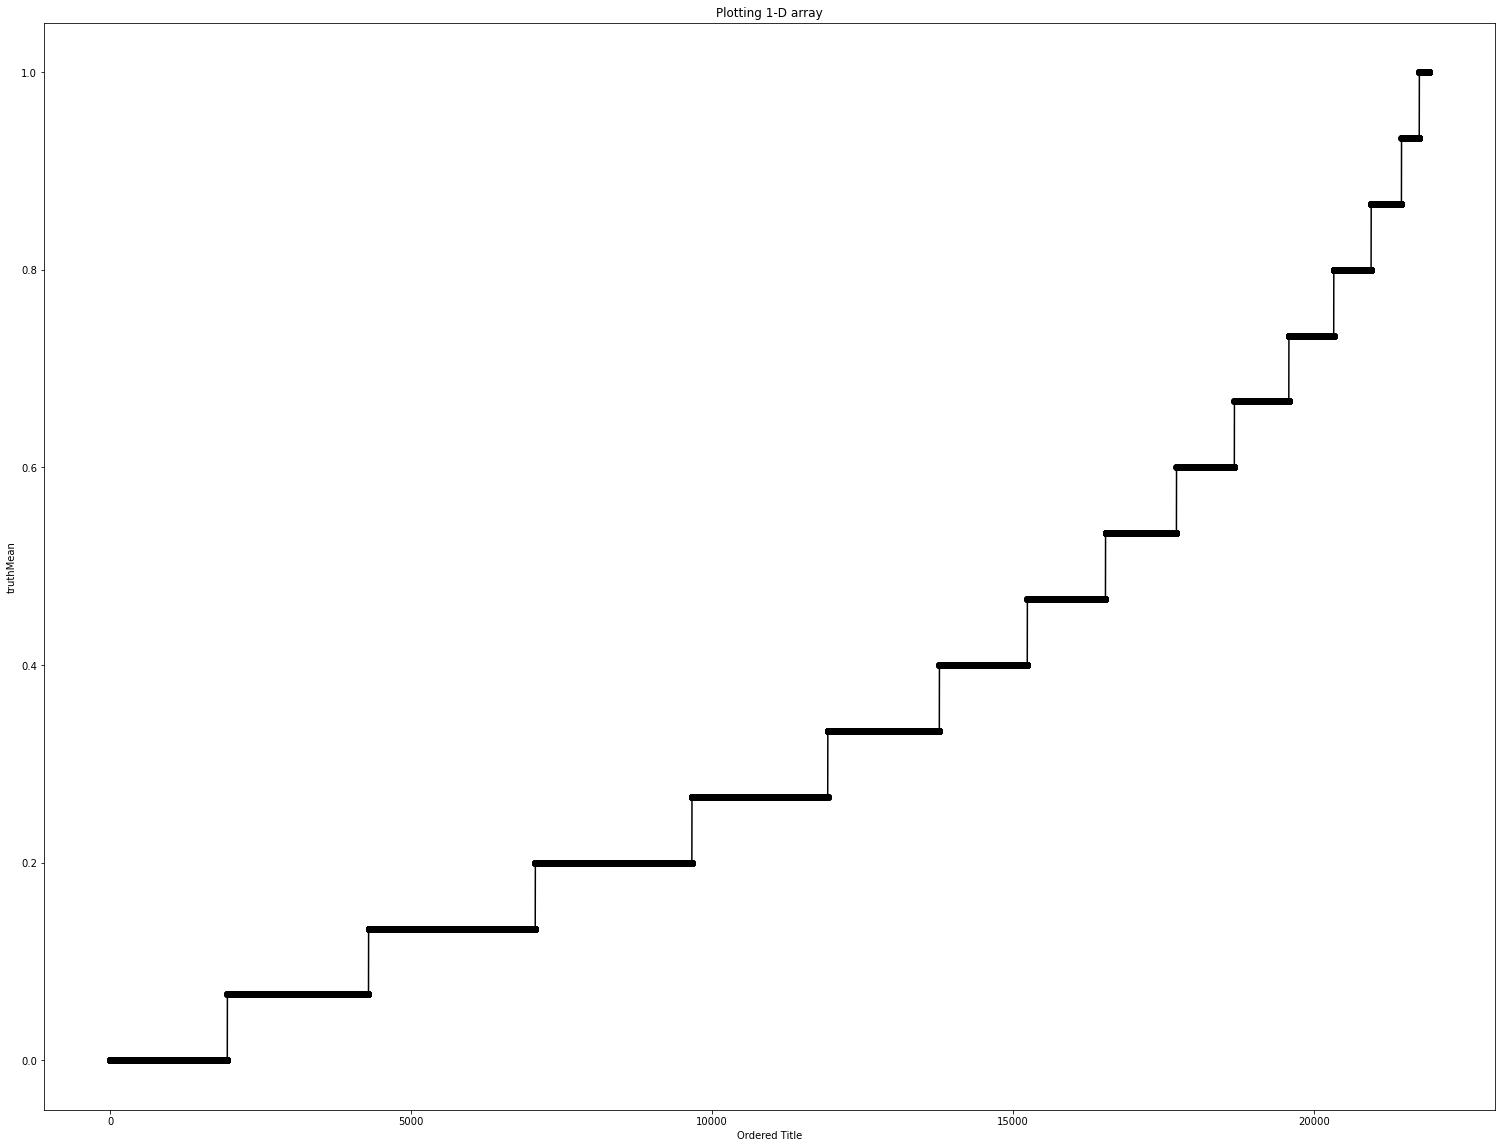

In [11]:
plt.figure(figsize=(26, 20))
plt.title("Plotting 1-D array")
plt.xlabel("Ordered Title")
plt.ylabel(actualOutput)
x = np.array(range(0, longueur))
y = np.array(trie)
plt.plot(x, y, color = "black", marker = "o", label = "Array elements")

In [12]:
ncf=[None] * (num_labels-1)
for i in range(num_labels-1):
    ncf[i] = trie[longueur * (i+1) // num_labels]
ncf

[]

In [13]:
def tokenize(sample):
    tokenized_sample = tokenizer(
            sample[inputColumn],   #  postText + ". Paru dans " + sample["Page name"], #+ ", le " + sample["Publish time"]
            # str(int(sample[LCfraction]*100)), # on donne direct le résultat pour voir si accuracy == 1
            #padding=True,
            #truncation=True,
            #max_length=30
            )

    fraction = sample[actualOutput]
    
    if num_labels == 1:
        tokenized_sample["labels"] = fraction
    else:
        tokenized_sample["labels"] = next((x for x, val in enumerate(ncf) if fraction < val), num_labels-1)
    
    
    # print( fraction, tokenized_sample["input_ids"], tokenized_sample["labels"], sample[inputColumn])
    
    return tokenized_sample

In [14]:
tokenized_curated = curated.map(tokenize) #, batched=True)

Loading cached processed dataset at Data/Curated\cache-132331471e51f6bf.arrow


In [15]:
tokenized_curated

Dataset({
    features: ['postText', 'targetTitle', 'targetDescription', 'truthMean', 'id', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 21912
})

In [16]:
tokenized_curated.to_pandas().describe()

,truthMean,labels
count,21912.000000,21912.000000
mean,0.327942,0.327942
std,0.250260,0.250260
min,0.000000,0.000000
25%,0.133333,0.133333
50%,0.266667,0.266667
75%,0.466667,0.466667
max,1.000000,1.000000


In [17]:
print(tokenized_curated[0:3])

{'postText': ['Panama Papers: Europol links 3,500 names to suspected criminals', 'The key to truly great chicken soup', 'Afghan policewomen face down their fears to serve'], 'targetTitle': ['Panama Papers: Europol links 3,500 names to suspected criminals', 'A Superior Chicken Soup ', '100 Women 2016: On the frontline with the women policing the peace in Afghanistan'], 'targetDescription': ['Law enforcement agency analysis uncovers probable matches connected to terrorism, money laundering and organised crime', 'For the best rendition of this American classic, start with a whole bird.', 'The Afghan women risking all to join the police.'], 'truthMean': [0.06666666666, 0.73333333332, 0.33333333330000003], 'id': ['804113781580328960', '804119512010424320', '804121272967983104'], 'input_ids': [[101, 8392, 19023, 131, 11854, 23043, 6743, 124, 117, 2260, 2666, 1106, 6321, 13037, 102], [101, 1109, 2501, 1106, 5098, 1632, 9323, 13128, 102], [101, 13099, 2021, 12821, 2354, 1339, 1205, 1147, 10434

In [18]:
tokenized_curated2 = tokenized_curated.train_test_split(splitFactor) # 0.2

In [19]:
tokenized_curated2['train'].to_pandas()

,postText,targetTitle,targetDescription,truthMean,id,input_ids,token_type_ids,attention_mask,labels
0,A contestant on The Jump has already been forc...,The Jump 2017 claims first casualty as Vogue W...,"Since it began in 2014, The Jump has made a na...",0.266667,828280526616145921,"[101, 138, 11201, 1113, 1109, 18454, 1144, 164...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.266667
1,A max deal for...Jrue Holiday? That's how craz...,The 10 NBA Free Agents Most Likely to Be Overp...,With another salary-cap spike on the way this ...,0.600000,841715429135532034,"[101, 138, 12477, 1775, 2239, 1111, 119, 119, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.600000
2,Leah Remini's Reddit AMA reveals juicy secrets...,Leah Remini's Reddit AMA reveals juicy secrets...,"Leah Remini, author of 'Troublemaker: Survivin...",0.533333,804133678003666946,"[101, 14809, 11336, 25685, 112, 188, 2156, 179...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.533333
3,This is how @imVkohli won #MichaelClarke's hea...,This Is How Virat Kohli Won Michael Clarke's H...,Former Aussie skipper Michael Clarke has words...,0.533333,842058017499680769,"[101, 1188, 1110, 1293, 137, 13280, 2559, 2718...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.533333
4,'Pain in my soul': Russia mourns plane victims,Russia mourns as search for bodies continues,A huge search operation is continuing for a Ru...,0.200000,813409889355759616,"[101, 112, 13304, 1107, 1139, 3960, 112, 131, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.200000
...,...,...,...,...,...,...,...,...,...
17524,"Finally, proof that not all cats are jerks.",One kitty's cuddly nature proves that not all ...,Twitter user @fish_size tweeted a picture in w...,0.533333,851495511517474816,"[101, 4428, 117, 6777, 1115, 1136, 1155, 11771...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.533333
17525,All NCAA Tournament games will be available on...,How to watch today's March Madness 2017 NCAA t...,Round two of the NCAA basketball tournament st...,0.400000,843818164756631552,"[101, 1398, 5089, 5629, 1638, 1209, 1129, 1907...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.400000
17526,WATCH LIVE: Attorneys of United Airlines passe...,Watch Live: Briefing with Attorneys of United ...,Attorneys and a family member for Dr. David Da...,0.600000,852537522945220609,"[101, 22751, 9481, 3048, 149, 26140, 131, 6867...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.600000
17527,See Harry Styles hanging from a helicopter on ...,Harry Styles Hangs From a Helicopter on 'Sign ...,As if the stakes weren't high enough already f...,0.200000,849403739664527361,"[101, 3969, 3466, 27881, 5205, 1121, 170, 7948...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.200000


In [20]:
tokenized_curated3 = tokenized_curated2.remove_columns(removeColumns)

In [21]:
tokenized_curated4 = tokenized_curated3

In [22]:
tokenized_curated4

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 17529
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 4383
    })
})

In [24]:
from datasets import load_metric
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    if num_labels == 1:
        metric = load_metric("mse")
        return metric.compute(predictions=logits, references=labels)
    elif num_labels == 2:
        predictions = np.argmax(logits, axis=-1)
        accuracy = accuracy_score(y_true=labels, y_pred=predictions)
#    recall = recall_score(y_true=labels, y_pred=predictions)
#    precision = precision_score(y_true=labels, y_pred=predictions)
        f1 = f1_score(y_true=labels, y_pred=predictions)
    # return metric.compute(predictions=predictions, references=labels) # , average = 'weighted'
        return {"accuracy": accuracy, "f1": f1 } #" "matthews_correlation":matthews_correlation precision": precision, "recall": recall, "f1": f1, 
    else:
        predictions = np.argmax(logits, axis=-1)
        metric = load_metric("matthews_correlation") # matthews_correlation, accuracy "glue", "mrpc") # , "sst2") #  stsb de la ouatte de phoque
        matthews_correlation = metric.compute(predictions=predictions, references=labels)
        # accuracy = accuracy_score(y_true=labels, y_pred=predictions)
        # f1 = f1_score(y_true=labels, y_pred=predictions)
        return matthews_correlation
        # return {"accuracy": accuracy}.update(matthews_correlation)

In [25]:
from transformers import TrainingArguments

training_args = TrainingArguments(modelPath,
                                  evaluation_strategy= "steps", # "epoch",
                                  eval_steps = 50, # Evaluation and Save happens every 50 steps
                                  save_total_limit = 5, # Only last 5 models are saved. Older ones are deleted.
                                  num_train_epochs = 4,
                                  #optim= 'adamw_torch',
                                  per_device_train_batch_size = 16,
                                  per_device_eval_batch_size = 16,
                                  #learning_rate=learning_rate,
                                  #weight_decay=weight_decay,
                                  #push_to_hub=push_to_hub,
                                  metric_for_best_model = 'accuracy' if num_labels == 2 else 'mse' if num_labels == 1 else 'matthews_correlation',
                                  load_best_model_at_end=True
                                 )

In [26]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer)

In [27]:
print(tokenized_curated4["train"][0:20])

{'input_ids': [[101, 138, 11201, 1113, 1109, 18454, 1144, 1640, 1151, 2257, 1106, 8204, 1170, 1217, 4475, 1219, 2013, 102], [101, 138, 12477, 1775, 2239, 1111, 119, 119, 119, 3108, 4175, 10450, 136, 1337, 112, 188, 1293, 4523, 1714, 4792, 1180, 1243, 1142, 1214, 102], [101, 14809, 11336, 25685, 112, 188, 2156, 17903, 6586, 1592, 7189, 179, 6592, 3457, 8858, 1104, 26973, 102], [101, 1188, 1110, 1293, 137, 13280, 2559, 2718, 8495, 1182, 1281, 108, 1847, 1658, 5815, 2391, 112, 188, 1762, 1118, 6546, 108, 5676, 3048, 6289, 1279, 112, 6594, 102], [101, 112, 13304, 1107, 1139, 3960, 112, 131, 2733, 182, 6334, 2316, 4261, 5256, 102], [101, 9434, 118, 3759, 3079, 1120, 142, 1643, 18982, 136, 9906, 3349, 107, 1103, 11679, 8661, 9102, 5033, 1212, 2746, 107, 1106, 1145, 1129, 1103, 1211, 14717, 102], [101, 1109, 7241, 11737, 15826, 1336, 1136, 10980, 19080, 1193, 117, 2693, 5200, 1143, 3702, 119, 102], [101, 2413, 112, 188, 5575, 5295, 131, 3434, 118, 1214, 118, 1385, 3804, 1485, 7433, 1814, 1171

In [28]:
from transformers import Trainer
from transformers import EarlyStoppingCallback

trainer = Trainer(model,
                  training_args,
                  train_dataset=tokenized_curated4["train"],
                  eval_dataset=tokenized_curated4["test"],
                  data_collator=data_collator,
                  tokenizer=tokenizer,
                  compute_metrics = compute_metrics,
                  callbacks = [EarlyStoppingCallback(early_stopping_patience=3)], #3
                  # optimizers=(torch.optim.AdamW, torch.optim.lr_scheduler.LambdaLR) 
                 )

In [29]:
# faire la boucle avec le trainer pytorch
# %pdb
if (modelPath != checkpoint):
    trainer.train()

C:\Users\herve\anaconda3\envs\PytorchGPU\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 17529
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 4384


Step,Training Loss,Validation Loss,Mse
50,No log,0.080491,0.080491
100,No log,0.054598,0.054598
150,No log,0.043672,0.043672
200,No log,0.033871,0.033871
250,No log,0.036403,0.036403
300,No log,0.027692,0.027692
350,No log,0.030656,0.030656
400,No log,0.034715,0.034715
450,No log,0.029738,0.029738
500,0.045800,0.027668,0.027668


***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16
Saving model checkpoint to Clickbait\checkpoint-500
Configuration saved in Clickbait\checkpoint-500\config.json
Model weights saved in Clickbait\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Clickbait\checkpoint-500\tokenizer_config.json
Special tokens file saved in Click

In [30]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 4383
  Batch size = 16


{'eval_loss': 0.030811205506324768,
 'eval_mse': 0.030811207778383778,
 'eval_runtime': 6.5624,
 'eval_samples_per_second': 667.894,
 'eval_steps_per_second': 41.753,
 'epoch': 2.05}

In [87]:
# Sauver le modèle sur le disque
if (modelPath != checkpoint):
    model.save_pretrained(modelPath)

In [88]:
if (modelPath != checkpoint):
    tokenizer.save_vocabulary(modelPath)

In [62]:
# Pour voir si on fait de l'overfitting, rien de mieux que de dessiner le graphe avec le jeu d'entrainement
overfitting = "train" #  "train" # "test"

In [63]:
model.to(torch.device("cuda:0"))
predictions = trainer.predict(tokenized_curated2[overfitting])

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: truthMean, targetDescription, id, targetTitle, postText. If truthMean, targetDescription, id, targetTitle, postText are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 17529
  Batch size = 16


In [64]:
predictions.predictions

array([[0.40938795],
       [0.68207115],
       [0.62470347],
       ...,
       [0.43381733],
       [0.2351021 ],
       [0.2475837 ]], dtype=float32)

In [65]:
predictions.metrics

{'test_loss': 0.015063533559441566,
 'test_mse': 0.015063533531756785,
 'test_runtime': 34.8594,
 'test_samples_per_second': 502.849,
 'test_steps_per_second': 31.441}

In [66]:
tct = tokenized_curated2[overfitting].to_pandas()

In [67]:
tct

,postText,targetTitle,targetDescription,truthMean,id,input_ids,token_type_ids,attention_mask,labels
0,A contestant on The Jump has already been forc...,The Jump 2017 claims first casualty as Vogue W...,"Since it began in 2014, The Jump has made a na...",0.266667,828280526616145921,"[101, 138, 11201, 1113, 1109, 18454, 1144, 164...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.266667
1,A max deal for...Jrue Holiday? That's how craz...,The 10 NBA Free Agents Most Likely to Be Overp...,With another salary-cap spike on the way this ...,0.600000,841715429135532034,"[101, 138, 12477, 1775, 2239, 1111, 119, 119, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.600000
2,Leah Remini's Reddit AMA reveals juicy secrets...,Leah Remini's Reddit AMA reveals juicy secrets...,"Leah Remini, author of 'Troublemaker: Survivin...",0.533333,804133678003666946,"[101, 14809, 11336, 25685, 112, 188, 2156, 179...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.533333
3,This is how @imVkohli won #MichaelClarke's hea...,This Is How Virat Kohli Won Michael Clarke's H...,Former Aussie skipper Michael Clarke has words...,0.533333,842058017499680769,"[101, 1188, 1110, 1293, 137, 13280, 2559, 2718...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.533333
4,'Pain in my soul': Russia mourns plane victims,Russia mourns as search for bodies continues,A huge search operation is continuing for a Ru...,0.200000,813409889355759616,"[101, 112, 13304, 1107, 1139, 3960, 112, 131, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.200000
...,...,...,...,...,...,...,...,...,...
17524,"Finally, proof that not all cats are jerks.",One kitty's cuddly nature proves that not all ...,Twitter user @fish_size tweeted a picture in w...,0.533333,851495511517474816,"[101, 4428, 117, 6777, 1115, 1136, 1155, 11771...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.533333
17525,All NCAA Tournament games will be available on...,How to watch today's March Madness 2017 NCAA t...,Round two of the NCAA basketball tournament st...,0.400000,843818164756631552,"[101, 1398, 5089, 5629, 1638, 1209, 1129, 1907...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.400000
17526,WATCH LIVE: Attorneys of United Airlines passe...,Watch Live: Briefing with Attorneys of United ...,Attorneys and a family member for Dr. David Da...,0.600000,852537522945220609,"[101, 22751, 9481, 3048, 149, 26140, 131, 6867...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.600000
17527,See Harry Styles hanging from a helicopter on ...,Harry Styles Hangs From a Helicopter on 'Sign ...,As if the stakes weren't high enough already f...,0.200000,849403739664527361,"[101, 3969, 3466, 27881, 5205, 1121, 170, 7948...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.200000


In [68]:
if num_labels == 1:
    tct[computedOutput] = predictions.predictions
else:
    tct[computedOutput] = np.argmax(predictions.predictions, axis=1)   

In [69]:
tct1 = tct.sort_values(actualOutput)
tct2 = tct.sort_values(computedOutput)

In [70]:
palette = ["r", "g", "b", "c", "m"]

In [71]:
if num_labels == 1:
    color1 = [val for val in tct1[computedOutput]]
    color2 = [val for val in tct1[actualOutput]]
else:
    color1 = [palette[val] for val in tct1[computedOutput]]
    color2 = [palette[val] for val in tct1[actualOutput]]

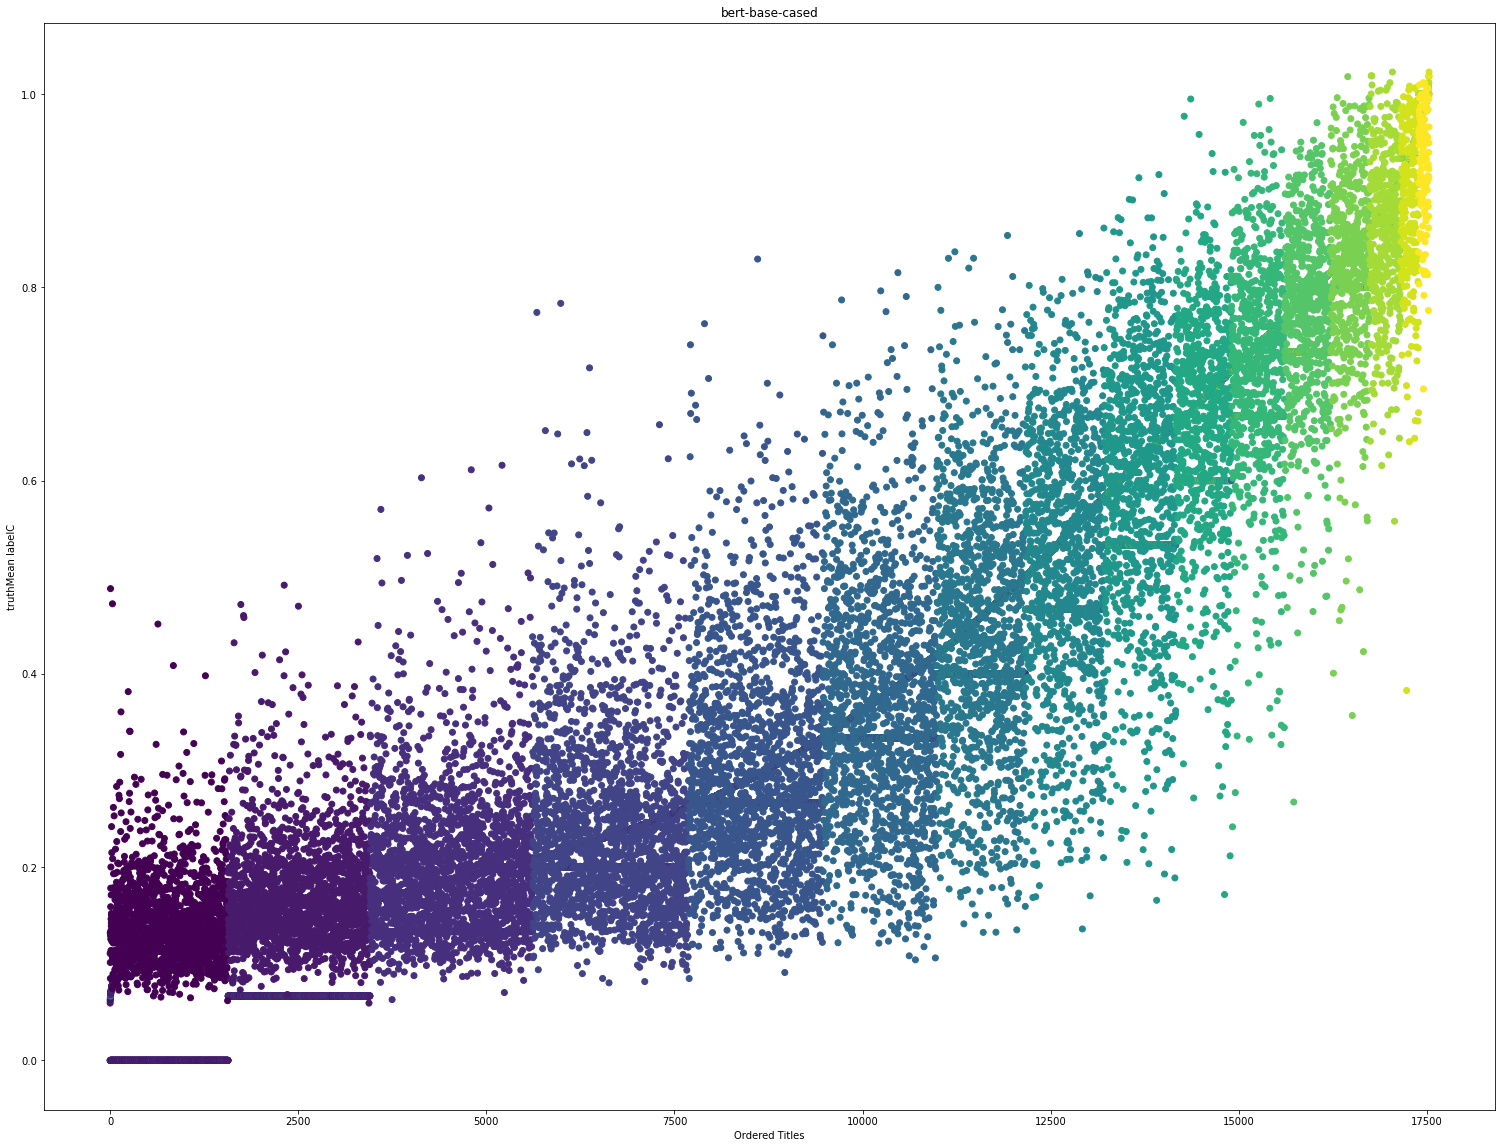

In [72]:
plt.figure(figsize=(26, 20))
plt.title(checkpoint)
plt.xlabel("Ordered Titles")

plt.ylabel(actualOutput + " " + computedOutput)

x = np.array(range(0, tct1.shape[0]))
y = tct1[actualOutput]
plt.scatter(x, y, c = color1, marker = "o", label = "Array elements")

x2 = np.array(range(0, tct2.shape[0]))
y2 = tct2[computedOutput]
plt.scatter(x2, y2, c = color1, marker = "o", label = "Array elements")

x3 = np.array(range(0, tct1.shape[0]))
y3 = tct1[computedOutput]
plt.scatter(x3, y3, c = color2, marker = "o", label = "Array elements")

In [73]:
tct

,postText,targetTitle,targetDescription,truthMean,id,input_ids,token_type_ids,attention_mask,labels,labelC
0,A contestant on The Jump has already been forc...,The Jump 2017 claims first casualty as Vogue W...,"Since it began in 2014, The Jump has made a na...",0.266667,828280526616145921,"[101, 138, 11201, 1113, 1109, 18454, 1144, 164...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.266667,0.409388
1,A max deal for...Jrue Holiday? That's how craz...,The 10 NBA Free Agents Most Likely to Be Overp...,With another salary-cap spike on the way this ...,0.600000,841715429135532034,"[101, 138, 12477, 1775, 2239, 1111, 119, 119, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.600000,0.682071
2,Leah Remini's Reddit AMA reveals juicy secrets...,Leah Remini's Reddit AMA reveals juicy secrets...,"Leah Remini, author of 'Troublemaker: Survivin...",0.533333,804133678003666946,"[101, 14809, 11336, 25685, 112, 188, 2156, 179...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.533333,0.624703
3,This is how @imVkohli won #MichaelClarke's hea...,This Is How Virat Kohli Won Michael Clarke's H...,Former Aussie skipper Michael Clarke has words...,0.533333,842058017499680769,"[101, 1188, 1110, 1293, 137, 13280, 2559, 2718...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.533333,0.618316
4,'Pain in my soul': Russia mourns plane victims,Russia mourns as search for bodies continues,A huge search operation is continuing for a Ru...,0.200000,813409889355759616,"[101, 112, 13304, 1107, 1139, 3960, 112, 131, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.200000,0.253051
...,...,...,...,...,...,...,...,...,...,...
17524,"Finally, proof that not all cats are jerks.",One kitty's cuddly nature proves that not all ...,Twitter user @fish_size tweeted a picture in w...,0.533333,851495511517474816,"[101, 4428, 117, 6777, 1115, 1136, 1155, 11771...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.533333,0.770086
17525,All NCAA Tournament games will be available on...,How to watch today's March Madness 2017 NCAA t...,Round two of the NCAA basketball tournament st...,0.400000,843818164756631552,"[101, 1398, 5089, 5629, 1638, 1209, 1129, 1907...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.400000,0.565038
17526,WATCH LIVE: Attorneys of United Airlines passe...,Watch Live: Briefing with Attorneys of United ...,Attorneys and a family member for Dr. David Da...,0.600000,852537522945220609,"[101, 22751, 9481, 3048, 149, 26140, 131, 6867...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.600000,0.433817
17527,See Harry Styles hanging from a helicopter on ...,Harry Styles Hangs From a Helicopter on 'Sign ...,As if the stakes weren't high enough already f...,0.200000,849403739664527361,"[101, 3969, 3466, 27881, 5205, 1121, 170, 7948...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.200000,0.235102


In [75]:
tct[[computedOutput, actualOutput]].describe()

,labelC,truthMean
count,17529.000000,17529.000000
mean,0.388661,0.329443
std,0.244480,0.251504
min,0.059281,0.000000
25%,0.182627,0.133333
50%,0.301582,0.266667
75%,0.578221,0.466667
max,1.022761,1.000000


In [76]:
tct.corr()

,truthMean,labels,labelC
truthMean,1.000000,1.000000,0.906419
labels,1.000000,1.000000,0.906419
labelC,0.906419,0.906419,1.000000


In [77]:
from transformers import pipeline

In [78]:
model.to(torch.device("cpu"))

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [79]:
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [80]:
classifier

In [81]:
classifier("Nous sommes très heureux de vous présenter la bibliothèque 🤗 Transformers.")

[{'label': 'LABEL_0', 'score': 0.6280205249786377}]

In [82]:
classifier(["The key to truly great chicken soup", "La clef d'une bonne soupe au poulet"])

Disabling tokenizer parallelism, we're using DataLoader multithreading already


[{'label': 'LABEL_0', 'score': 0.6771584153175354},
 {'label': 'LABEL_0', 'score': 0.6571547389030457}]

In [83]:
classifier("Traité de mathématiques amusantes.")

[{'label': 'LABEL_0', 'score': 0.6587210297584534}]

In [84]:
tct.loc[tct.labelC != tct.labels]

,postText,targetTitle,targetDescription,truthMean,id,input_ids,token_type_ids,attention_mask,labels,labelC
0,A contestant on The Jump has already been forc...,The Jump 2017 claims first casualty as Vogue W...,"Since it began in 2014, The Jump has made a na...",0.266667,828280526616145921,"[101, 138, 11201, 1113, 1109, 18454, 1144, 164...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.266667,0.409388
1,A max deal for...Jrue Holiday? That's how craz...,The 10 NBA Free Agents Most Likely to Be Overp...,With another salary-cap spike on the way this ...,0.600000,841715429135532034,"[101, 138, 12477, 1775, 2239, 1111, 119, 119, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.600000,0.682071
2,Leah Remini's Reddit AMA reveals juicy secrets...,Leah Remini's Reddit AMA reveals juicy secrets...,"Leah Remini, author of 'Troublemaker: Survivin...",0.533333,804133678003666946,"[101, 14809, 11336, 25685, 112, 188, 2156, 179...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.533333,0.624703
3,This is how @imVkohli won #MichaelClarke's hea...,This Is How Virat Kohli Won Michael Clarke's H...,Former Aussie skipper Michael Clarke has words...,0.533333,842058017499680769,"[101, 1188, 1110, 1293, 137, 13280, 2559, 2718...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.533333,0.618316
4,'Pain in my soul': Russia mourns plane victims,Russia mourns as search for bodies continues,A huge search operation is continuing for a Ru...,0.200000,813409889355759616,"[101, 112, 13304, 1107, 1139, 3960, 112, 131, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.200000,0.253051
...,...,...,...,...,...,...,...,...,...,...
17524,"Finally, proof that not all cats are jerks.",One kitty's cuddly nature proves that not all ...,Twitter user @fish_size tweeted a picture in w...,0.533333,851495511517474816,"[101, 4428, 117, 6777, 1115, 1136, 1155, 11771...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.533333,0.770086
17525,All NCAA Tournament games will be available on...,How to watch today's March Madness 2017 NCAA t...,Round two of the NCAA basketball tournament st...,0.400000,843818164756631552,"[101, 1398, 5089, 5629, 1638, 1209, 1129, 1907...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.400000,0.565038
17526,WATCH LIVE: Attorneys of United Airlines passe...,Watch Live: Briefing with Attorneys of United ...,Attorneys and a family member for Dr. David Da...,0.600000,852537522945220609,"[101, 22751, 9481, 3048, 149, 26140, 131, 6867...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.600000,0.433817
17527,See Harry Styles hanging from a helicopter on ...,Harry Styles Hangs From a Helicopter on 'Sign ...,As if the stakes weren't high enough already f...,0.200000,849403739664527361,"[101, 3969, 3466, 27881, 5205, 1121, 170, 7948...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.200000,0.235102


In [85]:
classifier("99% des gens n'arrivent pas à voir le chien sur cette image", return_all_scores=True)

[[{'label': 'LABEL_0', 'score': 0.6506125330924988}]]